# Look at RDPG models

## Preliminaries

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from giskard.plot import graphplot
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import (
    AdjacencySpectralEmbed,
    OmnibusEmbed,
    select_dimension,
    selectSVD,
)
from graspologic.match import GraphMatch
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from matplotlib.collections import LineCollection
from pkg.data import load_maggot_graph, load_palette
from pkg.io import savefig
from pkg.plot import set_theme

from pkg.utils import set_warnings
from sklearn.preprocessing import normalize
from src.visualization import adjplot
from src.visualization import CLASS_COLOR_DICT
from umap import AlignedUMAP
from factor_analyzer import Rotator
from src.visualization import matrixplot
from matplotlib.colors import Normalize, SymLogNorm
from matplotlib import cm
from giskard.utils import get_paired_inds

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "look_at_it_rdpg"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set2")

palette = dict(zip(["Left", "Right"], [colors[0], colors[1]]))
set_theme()

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Load and process data

In [2]:
CLASS_KEY = "merge_class"
node_palette = CLASS_COLOR_DICT
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"] | mg.nodes["accessory_neurons"]]
mg = mg[mg.nodes["hemisphere"].isin(["L", "R"])]
mg.to_largest_connected_component(verbose=True)
out_degrees = np.count_nonzero(mg.sum.adj, axis=0)
in_degrees = np.count_nonzero(mg.sum.adj, axis=1)
max_in_out_degree = np.maximum(out_degrees, in_degrees)
# TODO ideally we would OOS these back in?
keep_inds = np.arange(len(mg.nodes))[max_in_out_degree > 2]
remove_ids = np.setdiff1d(mg.nodes.index, mg.nodes.index[keep_inds])
print(f"Removed {len(remove_ids)} nodes when removing pendants.")
mg.nodes = mg.nodes.iloc[keep_inds]
mg.g.remove_nodes_from(remove_ids)
mg.to_largest_connected_component(verbose=True)
mg.nodes.sort_values("hemisphere", inplace=True)
mg.nodes["_inds"] = range(len(mg.nodes))
nodes = mg.nodes

raw_adj = mg.sum.adj.copy()

left_nodes = mg.nodes[mg.nodes["hemisphere"] == "L"]
left_inds = left_nodes["_inds"]
right_nodes = mg.nodes[mg.nodes["hemisphere"] == "R"]
right_inds = right_nodes["_inds"]

left_paired_inds, right_paired_inds = get_paired_inds(
    mg.nodes, pair_key="predicted_pair", pair_id_key="predicted_pair_id"
)
right_paired_inds_shifted = right_paired_inds - len(left_inds)

Removed 13 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## Embed the network using adjacency spectral embedding

In [3]:
def preprocess_for_embed(ll_adj, rr_adj, preprocess):
    if "binarize" in preprocess:
        ll_adj_to_embed = binarize(ll_adj)
        rr_adj_to_embed = binarize(rr_adj)

    if "rescale" in preprocess:
        ll_norm = np.linalg.norm(ll_adj_to_embed, ord="fro")
        rr_norm = np.linalg.norm(rr_adj_to_embed, ord="fro")
        mean_norm = (ll_norm + rr_norm) / 2
        ll_adj_to_embed *= mean_norm / ll_norm
        rr_adj_to_embed *= mean_norm / rr_norm
    return ll_adj_to_embed, rr_adj_to_embed


def embed(adj, n_components=40, ptr=False):
    if ptr:
        adj = pass_to_ranks(adj)
    elbow_inds, elbow_vals = select_dimension(augment_diagonal(adj), n_elbows=5)
    elbow_inds = np.array(elbow_inds)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    out_latent, in_latent = ase.fit_transform(adj)
    return out_latent, in_latent, ase.singular_values_, elbow_inds


def split_adj(adj):
    ll_adj = adj[np.ix_(left_inds, left_inds)]
    rr_adj = adj[np.ix_(right_inds, right_inds)]
    lr_adj = adj[np.ix_(left_inds, right_inds)]
    rl_adj = adj[np.ix_(right_inds, left_inds)]
    return ll_adj, rr_adj, lr_adj, rl_adj


def prescale_for_embed(adjs):
    norms = [np.linalg.norm(adj, ord="fro") for adj in adjs]
    mean_norm = np.mean(norms)
    adjs = [adjs[i] * mean_norm / norms[i] for i in range(len(adjs))]
    return adjs


def ase(adj, n_components=None):
    U, S, Vt = selectSVD(adj, n_components=n_components, algorithm="full")
    S_sqrt = np.diag(np.sqrt(S))
    X = U @ S_sqrt
    Y = Vt.T @ S_sqrt
    return X, Y


max_n_components = 40
preprocess = ["binarize", "rescale"]


ll_adj, rr_adj, _, _ = split_adj(raw_adj)

ll_adj_to_embed, rr_adj_to_embed = preprocess_for_embed(ll_adj, rr_adj, preprocess)

X_ll, Y_ll, left_sing_vals, left_elbow_inds = embed(
    ll_adj_to_embed, n_components=max_n_components
)
X_rr, Y_rr, right_sing_vals, right_elbow_inds = embed(
    rr_adj_to_embed, n_components=max_n_components
)

/Users/bpedigo/JHU_code/maggot/graspologic/graspologic/embed/ase.py:166: UserWarning:

Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.



### Plot screeplots

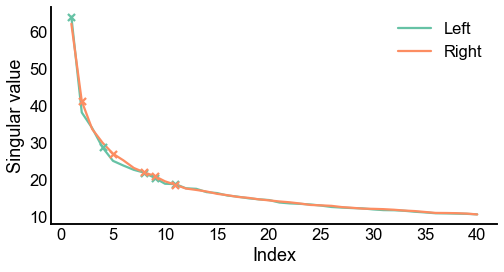

In [4]:


def screeplot(sing_vals, elbow_inds, color=None, ax=None, label=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.plot(range(1, len(sing_vals) + 1), sing_vals, color=color, label=label)
    plt.scatter(
        elbow_inds, sing_vals[elbow_inds - 1], marker="x", s=50, zorder=10, color=color
    )
    ax.set(ylabel="Singular value", xlabel="Index")
    return ax


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
screeplot(left_sing_vals, left_elbow_inds, color=palette["Left"], ax=ax, label="Left")
screeplot(
    right_sing_vals, right_elbow_inds, color=palette["Right"], ax=ax, label="Right"
)
ax.legend()
stashfig(f"screeplot")

## Align the left and the right embeddings

In [5]:


def joint_procrustes(
    data1,
    data2,
    method="orthogonal",
    paired_inds1=None,
    paired_inds2=None,
    swap=False,
    verbose=False,
):
    n = len(data1[0])
    if method == "orthogonal":
        procruster = OrthogonalProcrustes()
    elif method == "seedless":
        procruster = SeedlessProcrustes(init="sign_flips")
    elif method == "seedless-oracle":
        X1_paired = data1[0][paired_inds1, :]
        X2_paired = data2[0][paired_inds2, :]
        if swap:
            Y1_paired = data1[1][paired_inds2, :]
            Y2_paired = data2[1][paired_inds1, :]
        else:
            Y1_paired = data1[1][paired_inds1, :]
            Y2_paired = data2[1][paired_inds2, :]
        data1_paired = np.concatenate((X1_paired, Y1_paired), axis=0)
        data2_paired = np.concatenate((X2_paired, Y2_paired), axis=0)
        op = OrthogonalProcrustes()
        op.fit(data1_paired, data2_paired)
        procruster = SeedlessProcrustes(
            init="custom",
            initial_Q=op.Q_,
            optimal_transport_eps=1.0,
            optimal_transport_num_reps=100,
            iterative_num_reps=10,
        )
    data1 = np.concatenate(data1, axis=0)
    data2 = np.concatenate(data2, axis=0)
    currtime = time.time()
    data1_mapped = procruster.fit_transform(data1, data2)
    if verbose > 1:
        print(f"{time.time() - currtime:.3f} seconds elapsed for SeedlessProcrustes.")
    data1 = (data1_mapped[:n], data1_mapped[n:])
    return data1


def ase(adj, n_components=None):
    U, S, Vt = selectSVD(adj, n_components=n_components, algorithm="full")
    S_sqrt = np.diag(np.sqrt(S))
    X = U @ S_sqrt
    Y = Vt.T @ S_sqrt
    return X, Y


n_align_components = 32

X_ll = X_ll[:, :n_align_components]
Y_ll = Y_ll[:, :n_align_components]
X_rr = X_rr[:, :n_align_components]
Y_rr = Y_rr[:, :n_align_components]

X_ll, Y_ll = joint_procrustes(
    (X_ll, Y_ll),
    (X_rr, Y_rr),
    method="seedless-oracle",
    paired_inds1=left_paired_inds,
    paired_inds2=right_paired_inds_shifted,
)

XY_ll = np.concatenate((X_ll, Y_ll), axis=1)
XY_rr = np.concatenate((X_rr, Y_rr), axis=1)
n_final_components = 20
Z_ll, _ = ase(XY_ll, n_components=n_final_components)
Z_rr, _ = ase(XY_rr, n_components=n_final_components)

### Plot the left and the right embeddings in the same space after the alignment

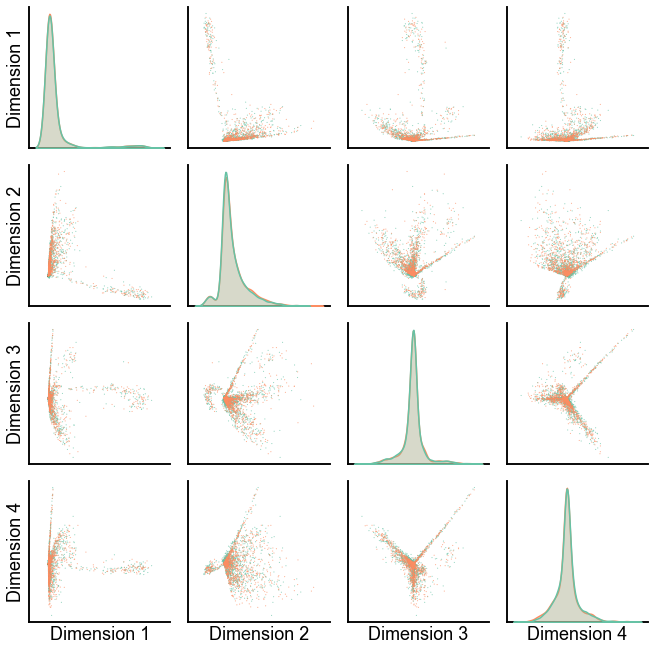

In [6]:


def add_connections(x1, x2, y1, y2, color="black", alpha=0.2, linewidth=0.2, ax=None):
    x1 = np.array(x1)
    x2 = np.array(x2)
    y1 = np.array(y1)
    y2 = np.array(y2)
    if ax is None:
        ax = plt.gca()

    coords = []
    for i in range(len(x1)):
        coords.append([[x1[i], y1[i]], [x2[i], y2[i]]])
    lc = LineCollection(
        coords,
        colors=color,
        linewidths=linewidth,
        alpha=alpha,
        zorder=0,
    )
    ax.add_collection(lc)


def plot_latents(
    left,
    right,
    title="",
    n_show=4,
    alpha=0.3,
    linewidth=0.4,
    connections=False,
    palette=None,
):
    if n_show > left.shape[1]:
        n_show = left.shape[1]
    plot_data = np.concatenate([left, right], axis=0)
    labels = np.array(["Left"] * len(left) + ["Right"] * len(right))
    pg = pairplot(
        plot_data[:, :n_show], labels=labels, title=title, size=5, palette=palette
    )
    if connections:
        axs = pg.axes
        for i in range(n_show):
            for j in range(n_show):
                if i != j:
                    ax = axs[i, j]
                    add_connections(
                        left[:, j],
                        right[:, j],
                        left[:, i],
                        right[:, i],
                        ax=ax,
                        alpha=alpha,
                        linewidth=linewidth,
                    )
    pg._legend.remove()
    return pg


plot_latents(X_ll, X_rr, palette=palette, connections=False)

## Examine the models

### Plot the RDPG $\hat{P}$ for the left and the right hemispheres

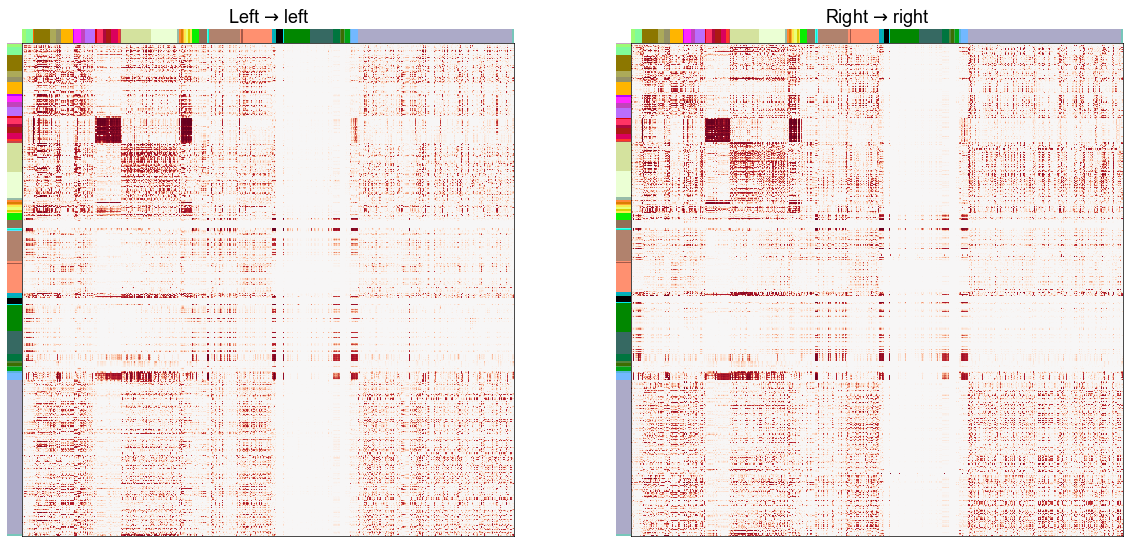

In [7]:

vmin = -1
vmax = 1
cmap = cm.get_cmap("RdBu_r")
norm = Normalize(vmin, vmax)
norm = SymLogNorm(linthresh=0.1, linscale=2, vmin=vmin, vmax=vmax, base=10)


n_components = 16
P_ll = X_ll[:, :n_components] @ Y_ll[:, :n_components].T
P_ll[P_ll < 0] = 0
P_rr = X_rr[:, :n_components] @ Y_rr[:, :n_components].T
P_rr[P_rr < 0] = 0

adjplot_kws = dict(
    colors="merge_class",
    palette=CLASS_COLOR_DICT,
    cmap=cmap,
    norm=norm,
    center=0,
    vmin=vmin,
    vmax=vmax,
    item_order="merge_class",
    cbar=False,
)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
adjplot(P_ll, meta=left_nodes, ax=ax, title=r"Left $\to$ left", **adjplot_kws)
ax = axs[1]
adjplot(P_rr, meta=right_nodes, ax=ax, title=r"Right $\to$ right", **adjplot_kws)
stashfig("phat-comparison")

### Experimental: try to make sense of the individual components

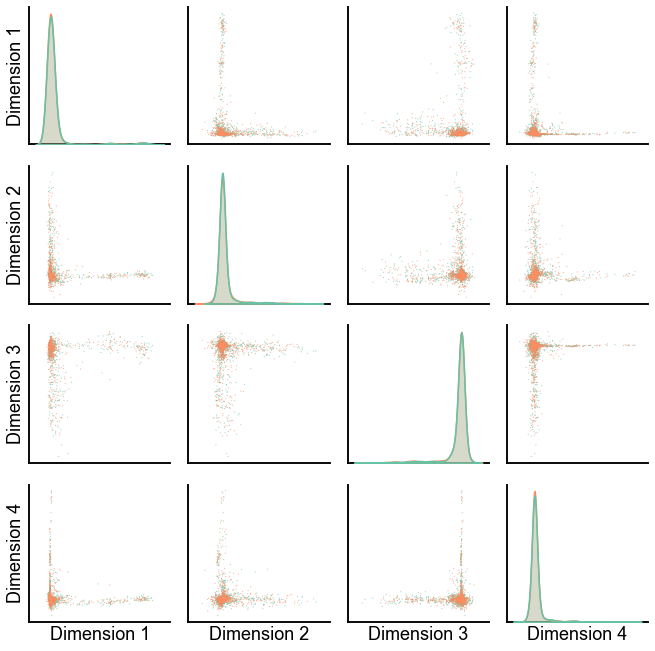

In [8]:
n_components = 20


def varimax(X):
    return Rotator(normalize=False).fit_transform(X)


n_left = len(X_ll)
X_concat = np.concatenate((X_ll[:, :n_components], X_rr[:, :n_components]), axis=0)

X_concat = varimax(X_concat)
X_ll_varimax = X_concat[:n_left]
X_rr_varimax = X_concat[n_left:]
plot_latents(X_ll_varimax, X_rr_varimax, palette=palette)

XY_rr = np.concatenate((X_rr[:, :n_components], Y_rr[:, :n_components]), axis=0)
XY_rr_varimax = varimax(XY_rr)

X_rr_varimax = XY_rr_varimax[: len(X_rr)]
Y_rr_varimax = XY_rr_varimax[len(X_rr) :]

#### Just for the right, examine the individual components

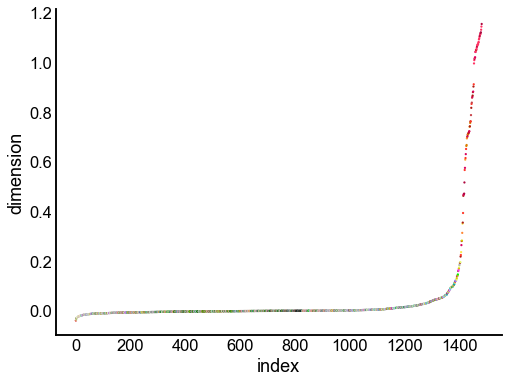

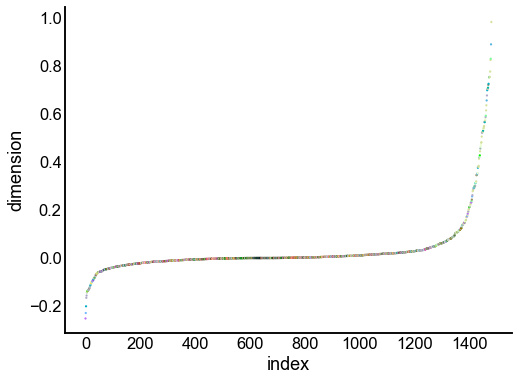

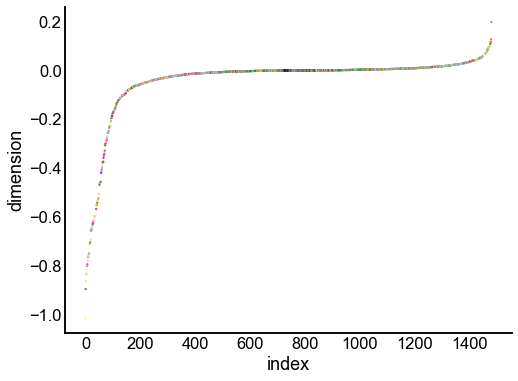

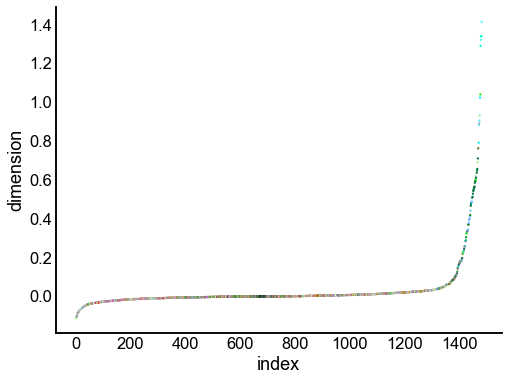

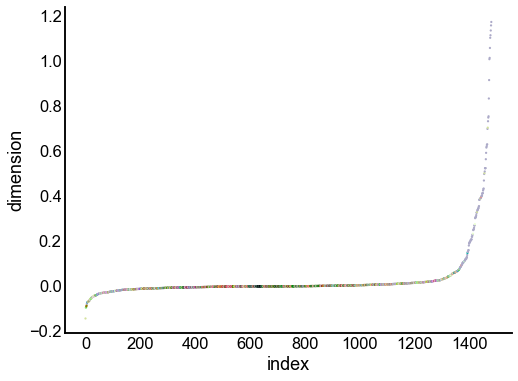

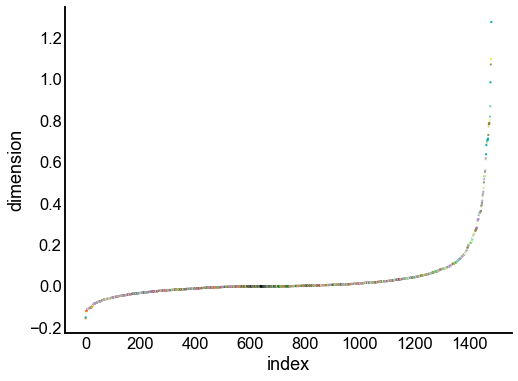

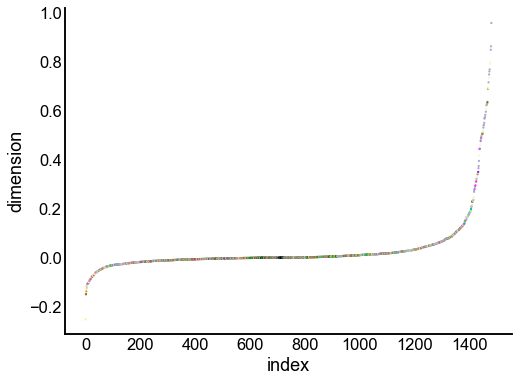

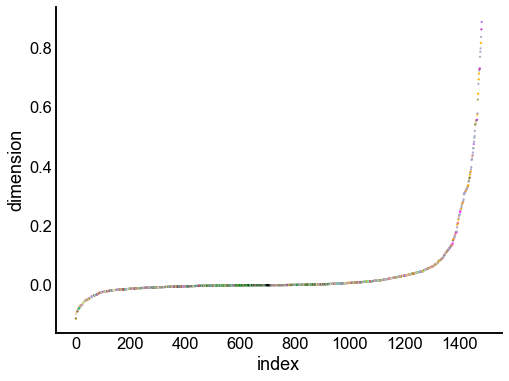

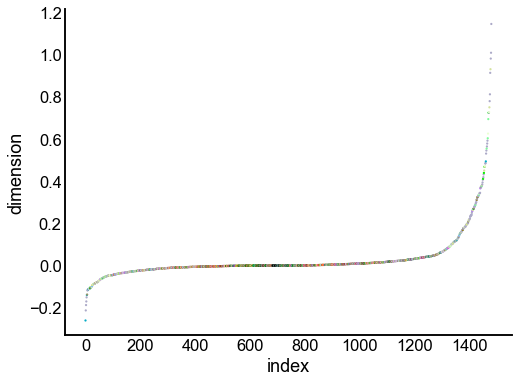

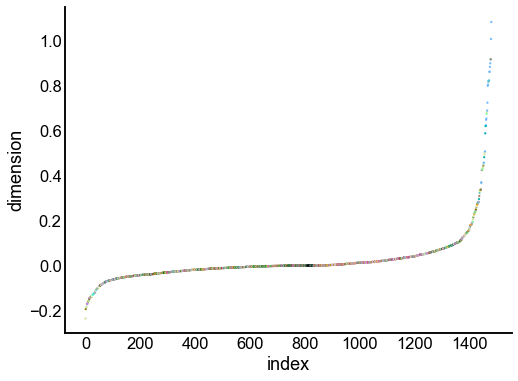

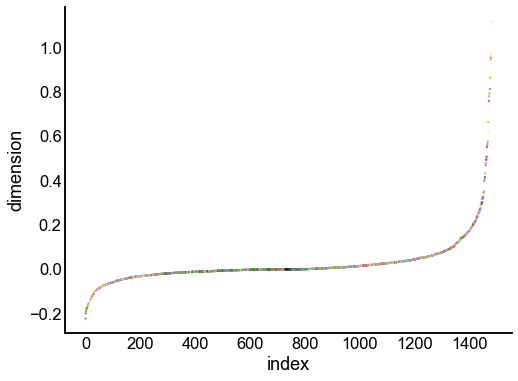

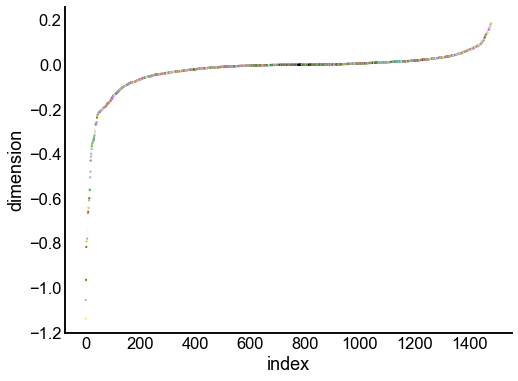

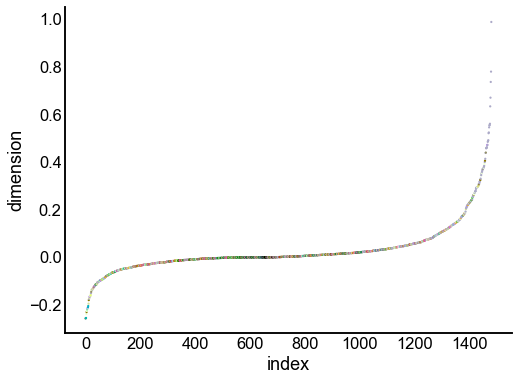

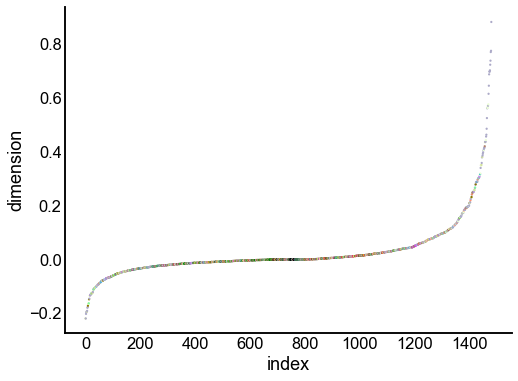

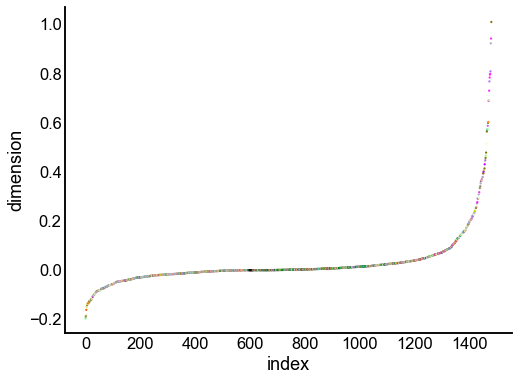

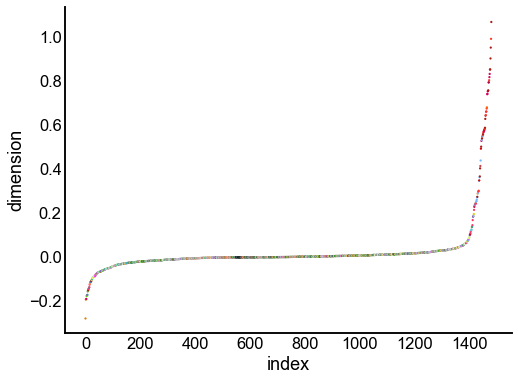

In [9]:

for dimension in X_rr_varimax.T[:16]:
    nodes = right_nodes.copy()
    nodes["dimension"] = dimension
    nodes.sort_values("dimension", inplace=True)
    nodes["index"] = np.arange(len(nodes))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.scatterplot(
        data=nodes,
        x="index",
        y="dimension",
        hue="merge_class",
        palette=CLASS_COLOR_DICT,
        legend=False,
        linewidth=0,
        s=5,
    )

#### Look at what the components mean in the probability space

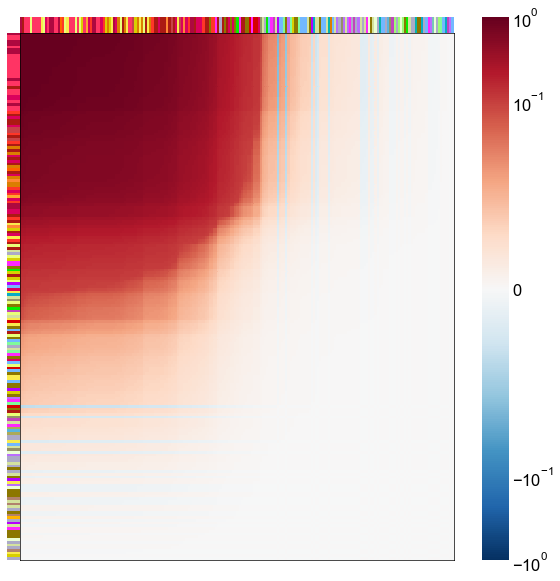

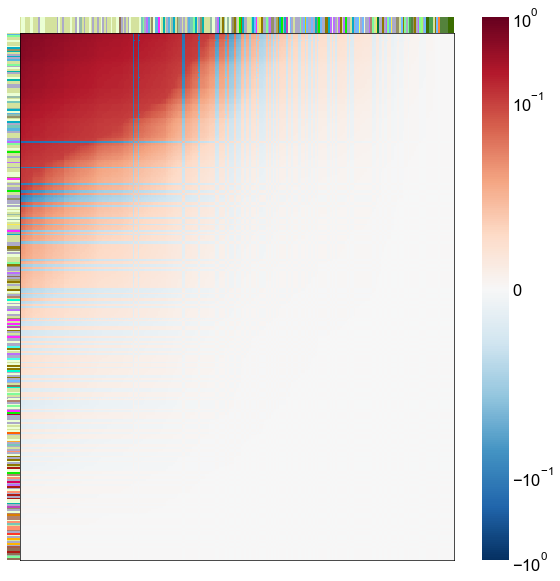

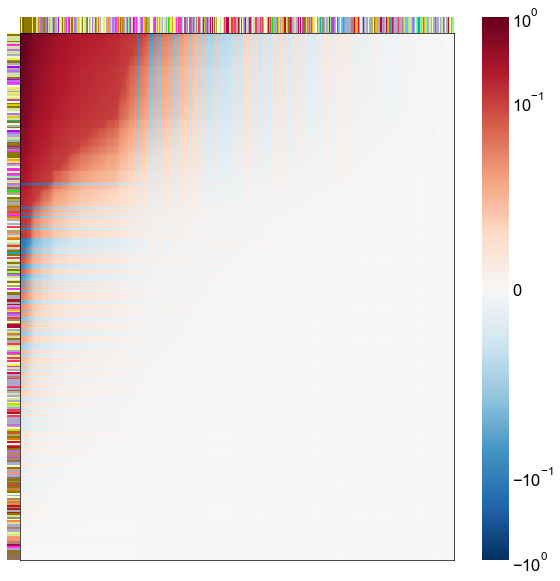

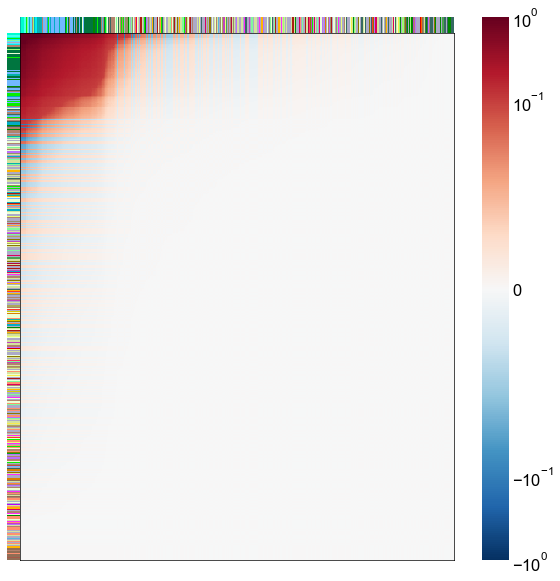

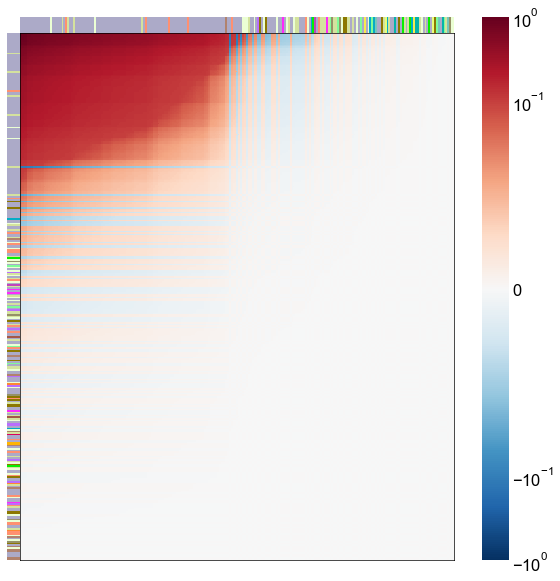

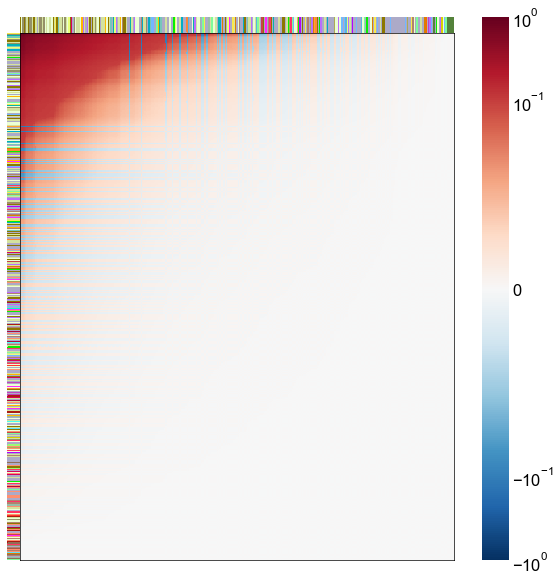

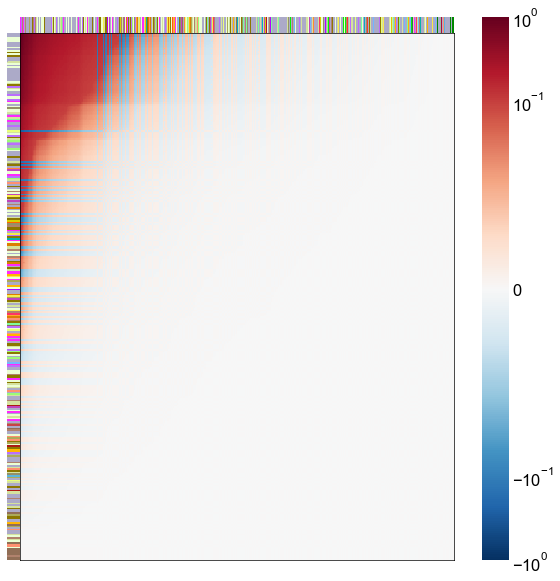

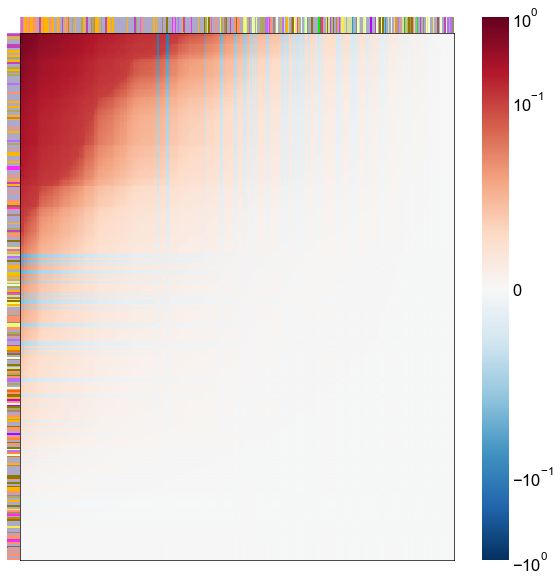

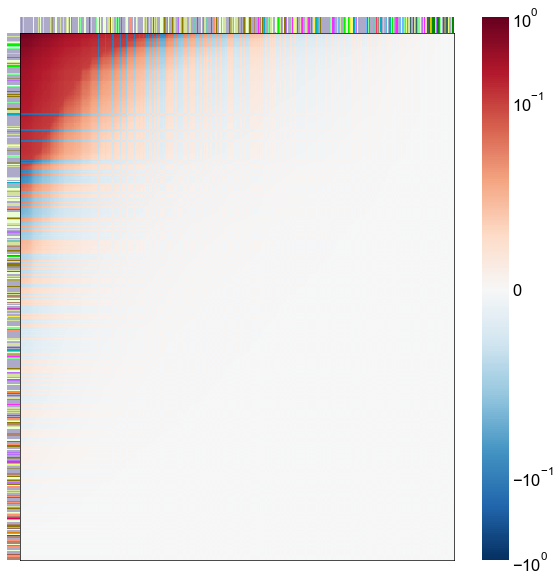

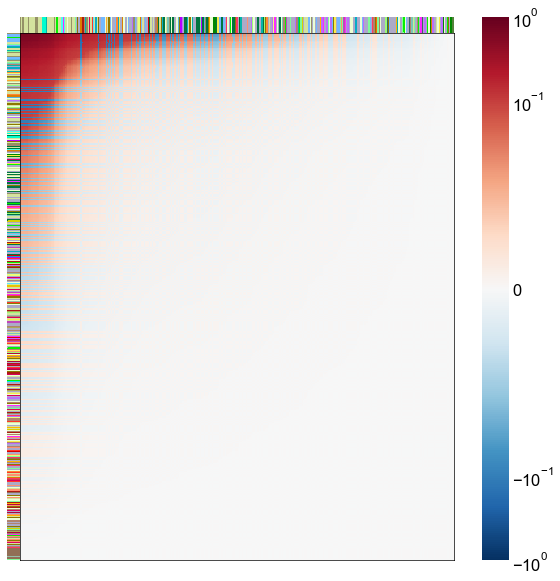

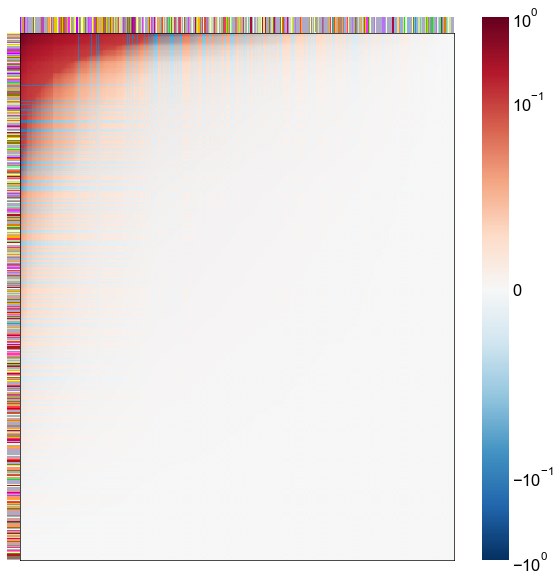

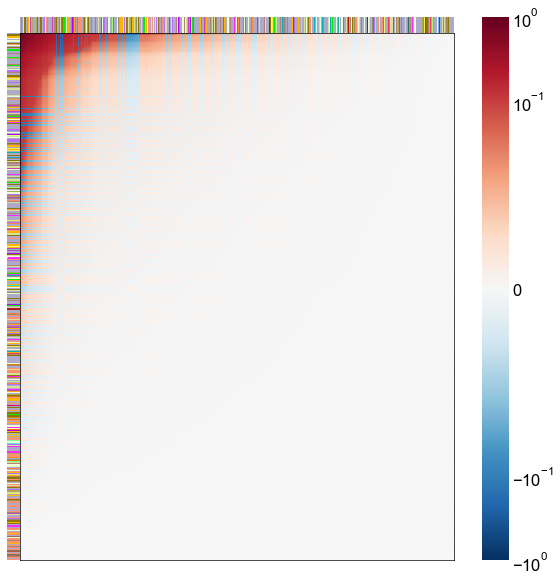

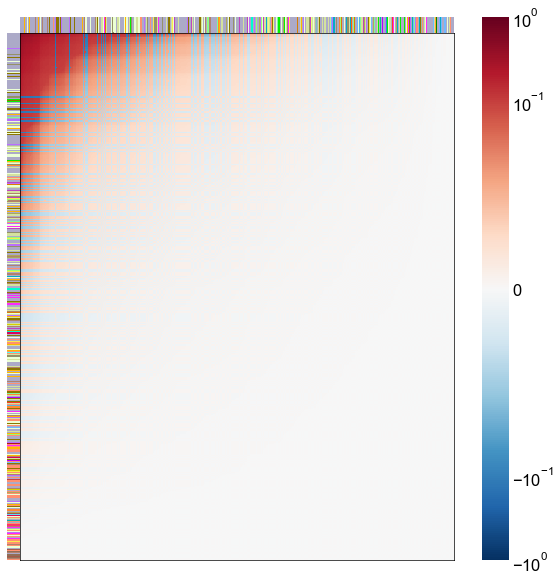

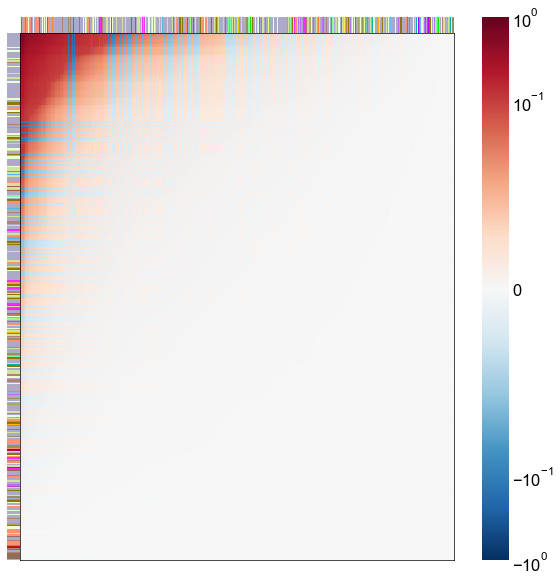

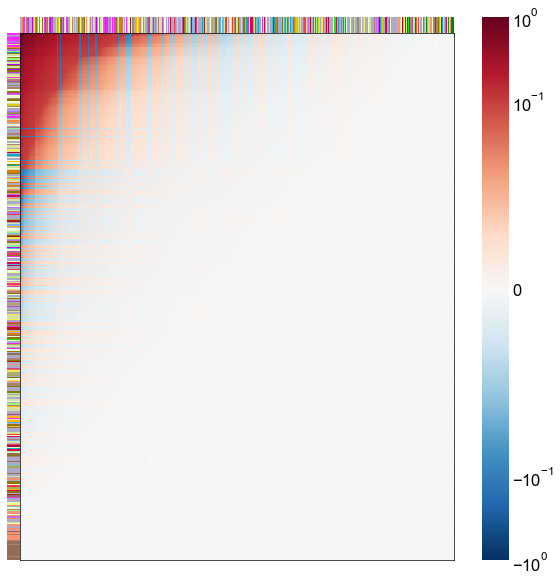

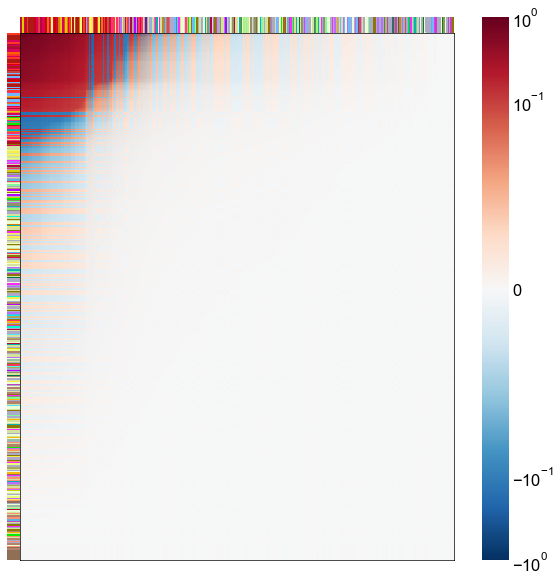

In [10]:

nodes = right_nodes.copy()
alpha = 10
quantile = 0.99
for i in range(16):
    x = X_rr_varimax[:, i]
    y = Y_rr_varimax[:, i]
    Phat = x[:, None] @ y[:, None].T
    abs_Phat = np.abs(Phat)
    q = np.quantile(abs_Phat, quantile)
    mask = abs_Phat > q
    row_used = mask.any(axis=0)
    col_used = mask.any(axis=1)
    col_nodes = nodes.iloc[col_used].copy()
    row_nodes = nodes.iloc[row_used].copy()
    sub_Phat = Phat[row_used][:, col_used]
    expected_out_degree = np.sum(np.abs(sub_Phat), axis=1)
    expected_in_degree = np.sum(np.abs(sub_Phat), axis=0)
    row_nodes["expected_out_degree"] = -expected_out_degree
    col_nodes["expected_in_degree"] = -expected_in_degree
    matrixplot(
        sub_Phat,
        row_meta=row_nodes,
        col_meta=col_nodes,
        row_colors="merge_class",
        col_colors="merge_class",
        row_palette=CLASS_COLOR_DICT,
        col_palette=CLASS_COLOR_DICT,
        row_item_order="expected_out_degree",
        col_item_order="expected_in_degree",
        cmap=cmap,
        norm=norm,
        center=0,
        vmin=vmin,
        vmax=vmax,
    )
    stashfig(f"right-phat-component-{i}")

In [11]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:02:10.024765
Completed at 2021-05-10 17:35:29.526520
----
